In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS
import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh

In [4]:
site_key = 'Foliage'
freq_key = 'lf_'

In [5]:
bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

In [6]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 2000

In [7]:
print(f'Looking at {fig_details["site_name"]}')

Looking at Foliage


/Users/adityakrishna/duty-cycle-investigation/notebooks/../src/bout_clustering.py:42: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  location_sum_df = pd.read_csv(f'../data/2022_bd2_summary/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022.csv', index_col=0)


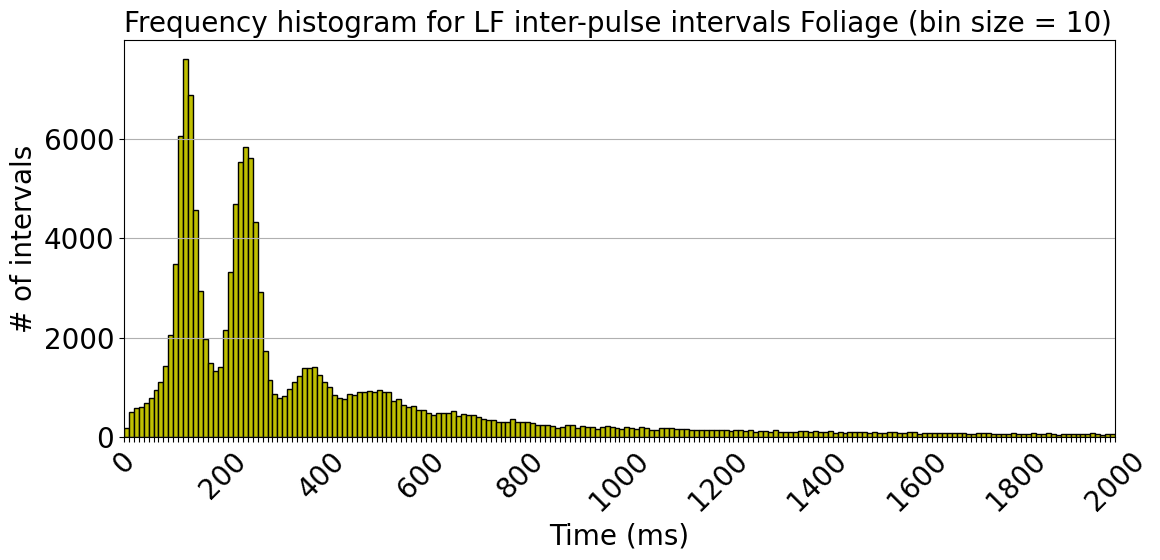

In [8]:
ipis_f, hist_f = bt_plt.plot_ipi_hist(bout_params, fig_details)

In [9]:
ipis_loc, hist_loc = bt_clustering.get_histogram(bout_params, fig_details)
intervals_ms, survival = bt_clustering.get_log_survival(hist_loc)

fast_process = bt_clustering.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
fast_process = bt_clustering.calculate_exponential_coefficients(fast_process)

slow_process = bt_clustering.regress_around_slow_intervals(intervals_ms, survival)
slow_process = bt_clustering.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = bt_clustering.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = bt_clustering.get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = bt_clustering.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

/Users/adityakrishna/duty-cycle-investigation/notebooks/../src/bout_clustering.py:42: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  location_sum_df = pd.read_csv(f'../data/2022_bd2_summary/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022.csv', index_col=0)


Fagen&Young method has 1295329894 missassigned points
Slater method has 1420229 missassigned points
Sibly method has 1411683 missassigned points
Optim BCI has less misassignments than BCI? True
8545 more points assigned correctly


In [10]:
fast_process, slow_process

({'metrics': LinregressResult(slope=-0.002246795782744993, intercept=12.051604428937091, rvalue=-0.9866323990508062, pvalue=3.4148262994902154e-48, stderr=4.831341258547039e-05, intercept_stderr=0.016805846783608393),
  'indices': range(0, 61),
  'lambda': 0.002246795782744993,
  'num_intervals_slater': 76274909.58999322},
 {'metrics': LinregressResult(slope=-3.5627905878956667e-07, intercept=6.1344797037891725, rvalue=-0.9969987361272323, pvalue=0.0, stderr=4.8203455552052434e-11, intercept_stderr=0.00026802380638765006),
  'indices': array([False, False, False, ..., False, False, False]),
  'lambda': 3.5627905878956667e-07,
  'num_intervals_slater': 1295329893.8569014})

In [11]:
nlin_results

{'solution': array([7.56965270e+07, 2.25980130e-03, 1.29532996e+09, 3.56279077e-07]),
 'fast_num_intervals': 75696526.96964684,
 'fast_lambda': 0.002259801296778854,
 'slow_num_intervals': 1295329960.2435212,
 'slow_lambda': 3.5627907685686906e-07,
 'bci': 2618.0254863688915}

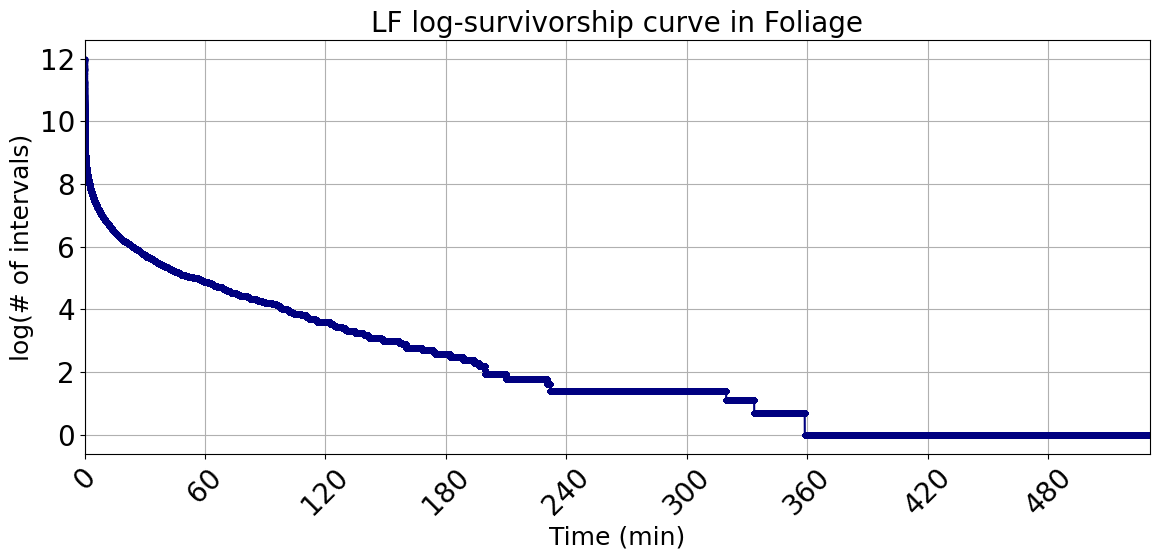

In [12]:
bt_plt.plot_log_survival(intervals_ms, survival, fig_details)

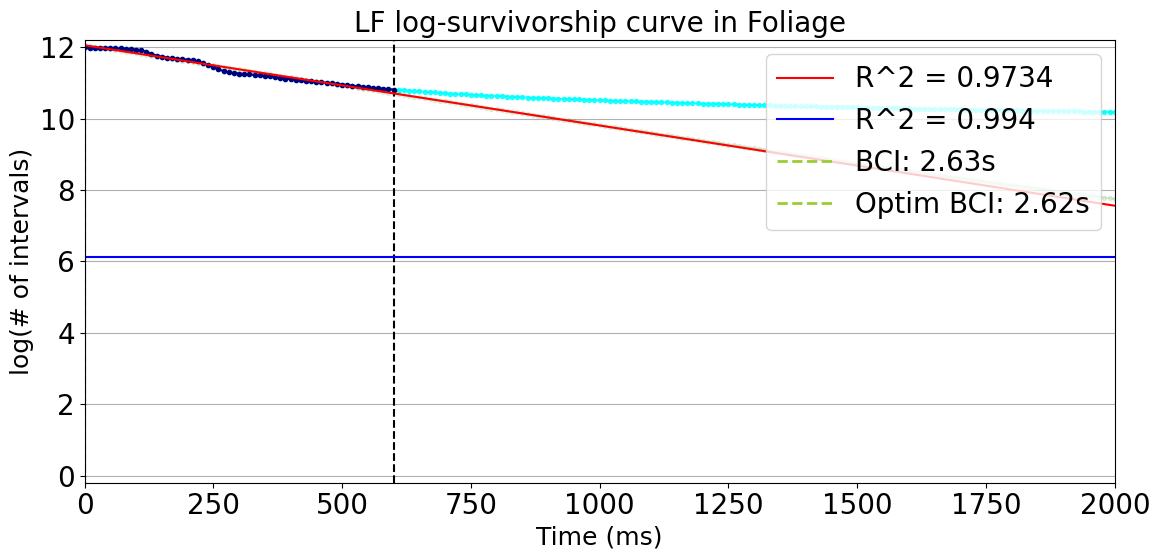

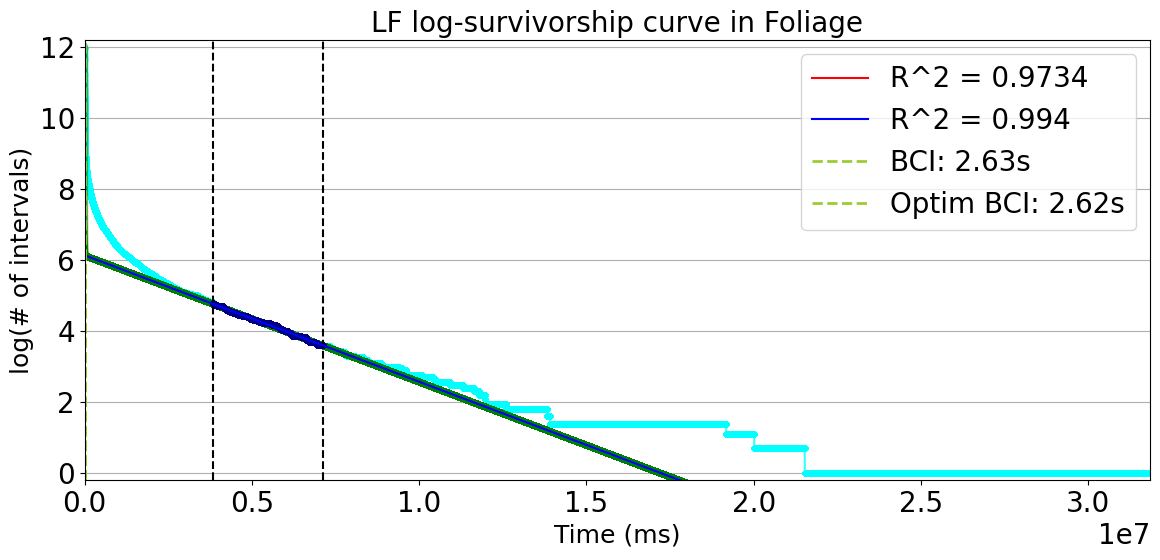

In [13]:
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

21 20


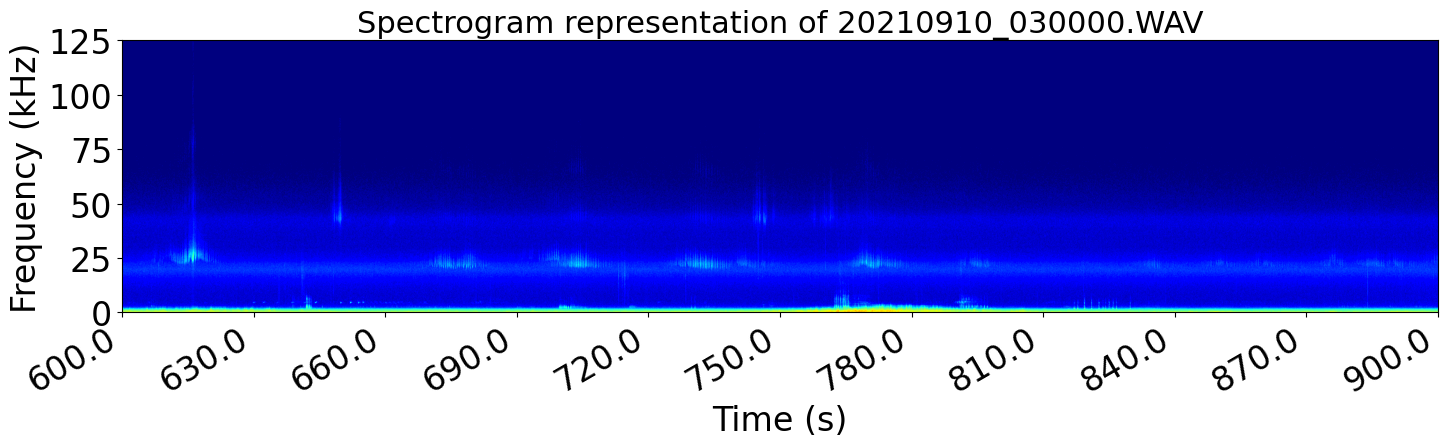

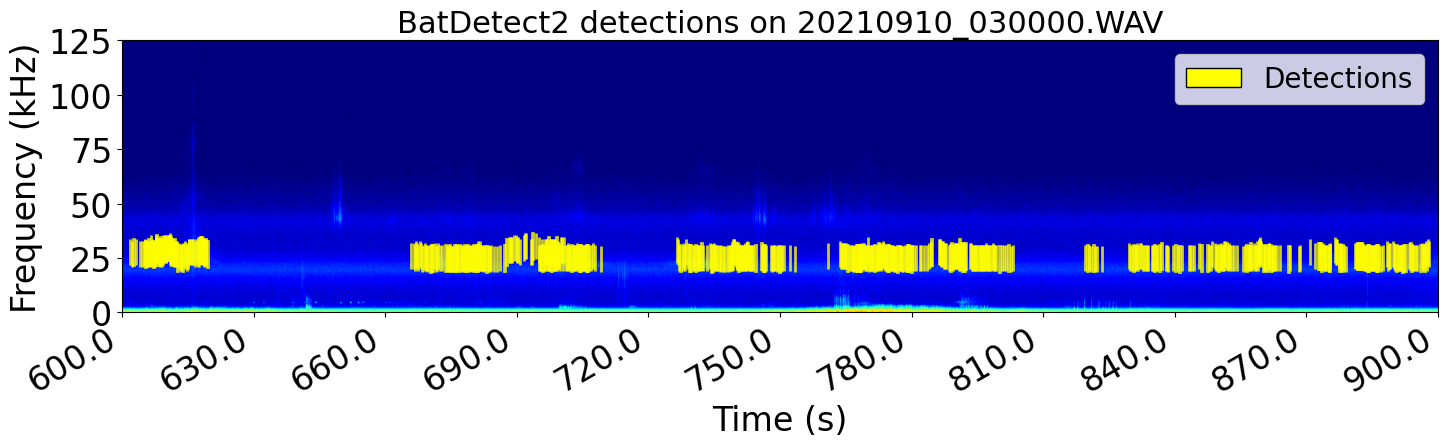

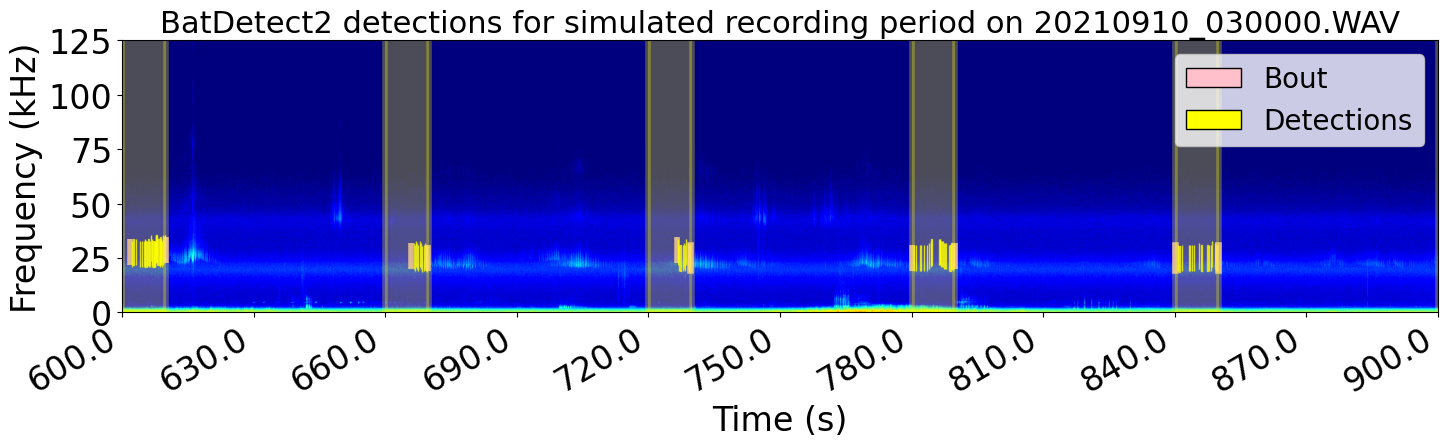

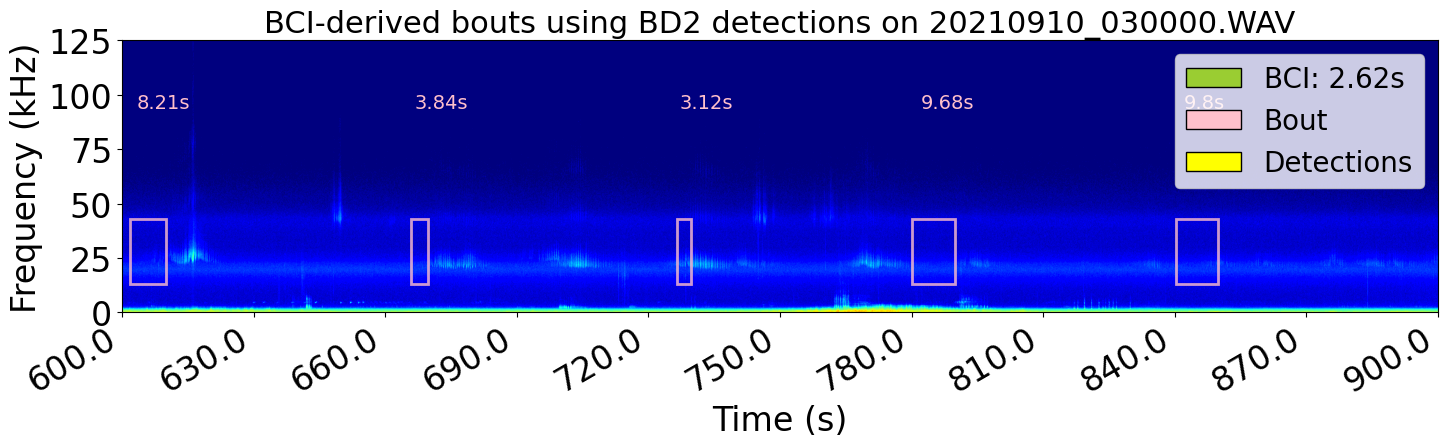

In [14]:
file_path = Path('../../Documents/Research/Lab_related/example/original_recording/recover-20210912_unit2/UBNA_002/20210910_030000.WAV')
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 600
duration = 300
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 55 # hide anything below -rm_dB dB

bout_params['bci'] = nlin_results['bci']

data_params = dict()
data_params['dc_tag'] = '10of60'
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path('../batdetect2_outputs/recover-20210912/Foliage/bd2_20210910_030000.csv')
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
lower_freq_bound = data_params['freq_tags'][0]
lowest_freq_in_dets = batdetect2_predictions_no_dutycycle['low_freq'].min()
upper_freq_bound = data_params['freq_tags'][1]
highest_freq_in_dets = batdetect2_predictions_no_dutycycle['high_freq'].max()
assert(np.logical_and(highest_freq_in_dets < upper_freq_bound, lowest_freq_in_dets > lower_freq_bound))
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['dc_tag'])
batdetect2_preds_with_bouttags = bt_clustering.classify_bouts_in_single_bd2_output(batdetect2_predictions, bout_params)
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]

bout_metrics = bt_clustering.construct_bout_metrics_from_classified_dets(batdetect2_preds_with_bouttags)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, data_params, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

In [15]:
intervals = pd.to_datetime(batdetect2_predictions_no_dutycycle['call_start_time']) - pd.to_datetime(batdetect2_predictions_no_dutycycle['call_end_time']).shift(1)
batdetect2_predictions_no_dutycycle.insert(0, 'time_from_prev_call_end_time', intervals)
batdetect2_predictions_no_dutycycle = batdetect2_predictions_no_dutycycle.reset_index()
batdetect2_predictions_no_dutycycle.drop(columns=batdetect2_predictions_no_dutycycle.columns[0], inplace=True)
batdetect2_predictions_no_dutycycle

,time_from_prev_call_end_time,start_time_wrt_ref,end_time_wrt_ref,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Recover Folder,SD Card,Site name
0,NaT,6.9325,6.9418,2021-09-10 03:04:00,2021-09-10 03:04:06.932500,2021-09-10 03:04:06.941800,246.9325,246.9418,28046.0,37602.0,Echolocation,Eptesicus serotinus,0.402,0.549,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage
1,0 days 00:00:00.274700,7.2165,7.2264,2021-09-10 03:04:00,2021-09-10 03:04:07.216500,2021-09-10 03:04:07.226400,247.2165,247.2264,28046.0,38133.0,Echolocation,Eptesicus serotinus,0.415,0.573,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage
2,0 days 00:00:00.126100,7.3525,7.3627,2021-09-10 03:04:00,2021-09-10 03:04:07.352500,2021-09-10 03:04:07.362700,247.3525,247.3627,28046.0,38892.0,Echolocation,Eptesicus serotinus,0.422,0.555,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage
3,0 days 00:00:00.108800,7.4715,7.4794,2021-09-10 03:04:00,2021-09-10 03:04:07.471500,2021-09-10 03:04:07.479400,247.4715,247.4794,27187.0,42404.0,Echolocation,Eptesicus serotinus,0.546,0.763,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage
4,0 days 00:00:00.111100,7.5905,7.6001,2021-09-10 03:04:00,2021-09-10 03:04:07.590500,2021-09-10 03:04:07.600100,247.5905,247.6001,28046.0,37383.0,Echolocation,Eptesicus serotinus,0.376,0.530,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2888,0 days 00:00:00.470300,41.4465,41.4565,2021-09-10 03:29:00,2021-09-10 03:29:41.446500,2021-09-10 03:29:41.456500,1781.4465,1781.4565,25468.0,32664.0,Echolocation,Nyctalus leisleri,0.273,0.584,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage
2889,0 days 00:00:00.122000,41.5785,41.5891,2021-09-10 03:29:00,2021-09-10 03:29:41.578500,2021-09-10 03:29:41.589100,1781.5785,1781.5891,26328.0,32298.0,Echolocation,Nyctalus leisleri,0.328,0.577,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage
2890,0 days 00:00:00.349400,41.9385,41.9477,2021-09-10 03:29:00,2021-09-10 03:29:41.938500,2021-09-10 03:29:41.947700,1781.9385,1781.9477,26328.0,34069.0,Echolocation,Eptesicus serotinus,0.294,0.614,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage
2891,0 days 00:00:00.113800,42.0615,42.0702,2021-09-10 03:29:00,2021-09-10 03:29:42.061500,2021-09-10 03:29:42.070200,1782.0615,1782.0702,25468.0,34393.0,Echolocation,Eptesicus serotinus,0.393,0.600,-1,/Users/adityakrishna/Documents/Research/Lab_re...,recover-20210912_unit2,UBNA_002,Foliage


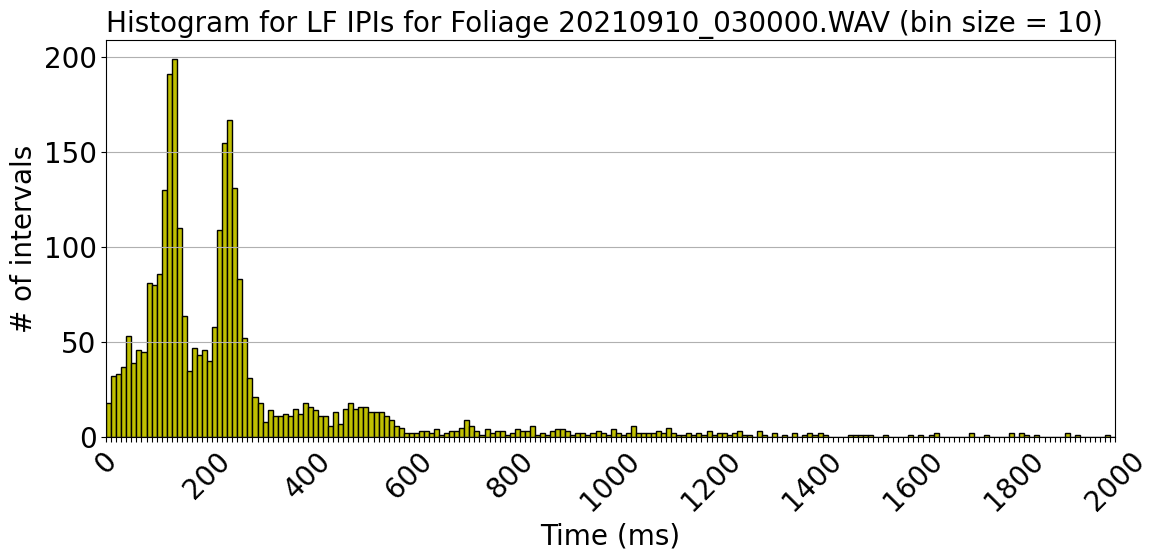

In [16]:
intervals = batdetect2_predictions_no_dutycycle['time_from_prev_call_end_time'].values
valid_intervals = intervals[~np.isnan(intervals)]
ipis_ms = valid_intervals.astype('float32')/1e6
assert((len(ipis_ms)+1) == len(batdetect2_predictions_no_dutycycle))

plt.rcParams.update({'font.size' : 20})
plt.figure(figsize=(12, 6))

fig_details['time_end'] = 2000

plt.title(f"Histogram for {fig_details['freq_group']}IPIs for {fig_details['site_name']} {file_path.name} (bin size = {fig_details['bin_step']})", loc='left', fontsize=20)
hist_bins = np.arange(0, fig_details['time_end']+fig_details['bin_step'], fig_details['bin_step'])
histogram = plt.hist(ipis_ms, bins=hist_bins, facecolor='y', edgecolor='k')
plt.grid(axis='y')
bin_ticks = hist_bins.round(3)
bin_labels = [''] * len(bin_ticks)


bin_labels[::int(fig_details['time_end']/(10*fig_details['bin_step']))] = bin_ticks[::int(fig_details['time_end']/(10*fig_details['bin_step']))]

plt.xticks(bin_ticks, bin_labels, rotation=45)
plt.ylabel('# of intervals', fontsize=20)
plt.xlabel('Time (ms)', fontsize=20)
plt.xlim(0, fig_details['time_end'])
plt.tight_layout()
plt.show()

In [17]:
batdetect2_predictions = bt_clustering.classify_bouts_in_location_summary(bout_params)
bout_metrics = bt_clustering.construct_bout_metrics_from_classified_dets(batdetect2_predictions)
bout_durations = bout_metrics['bout_duration_in_secs'].values

/Users/adityakrishna/duty-cycle-investigation/notebooks/../src/bout_clustering.py:149: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv(f'../data/2022_bd2_summary/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022.csv')


In [18]:
round(np.mean(bout_durations, axis=0), 4), np.median(bout_durations, axis=0)

(4.1632, 2.3979)

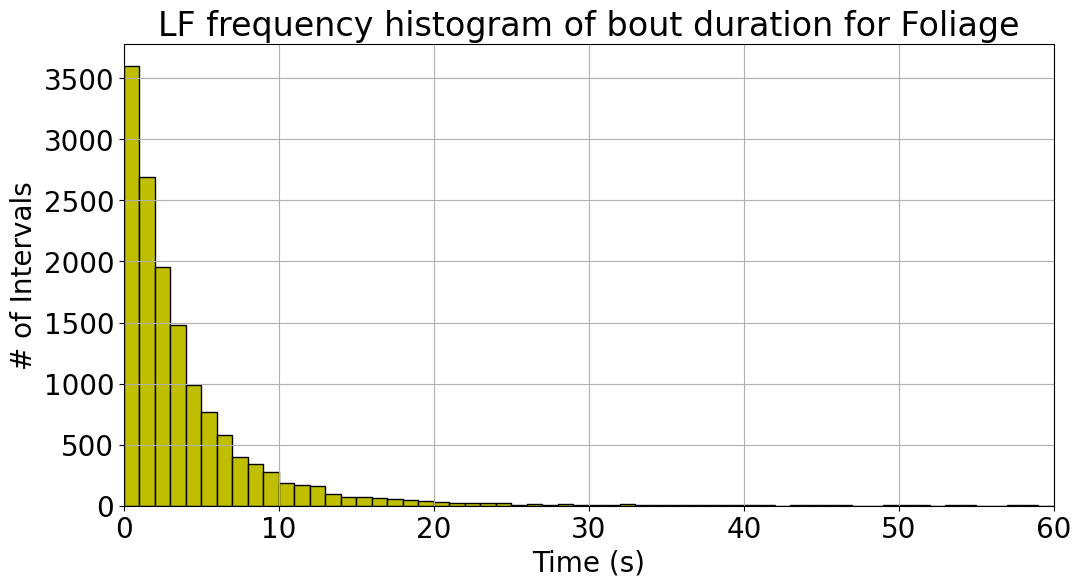

In [19]:
plt.figure(figsize=(12, 6))
plt.title(f"{fig_details['freq_group']}frequency histogram of bout duration for {fig_details['site_name']}")
plt.hist(bout_durations, bins=np.arange(0, bout_durations.max()+1, 1), facecolor='y', edgecolor='k')
plt.xlim(0, 60)
plt.xlabel('Time (s)')
plt.grid(which='both')
plt.ylabel('# of Intervals')
plt.show()